# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">Overview</p>

This notebook presents a comprehensive experimental framework designed to address specific objectives within the scope of avian population modeling. Due to constraints on Kaggle, the notebook is strategically divided into five sections, each dedicated to a distinct facet of the comprehensive analysis. The initial section focuses on detailing the experimental design for the first type of experiment, which involves modeling the entirety of bird populations without specific constraints, with a particular emphasis on a chosen bird species.

**Experiment Type 1: Modeling All Data for a Bird Species**

**Objective:**
The primary objective of this experiment is to model avian populations collectively, without imposing specific limitations, while centering attention on a designated bird species.

**Experimental Conditions:**
For this experiment, the selection of a bird species is pivotal. The chosen species should be both abundant and diverse, characterized by a substantial number of presence records. This selection criterion ensures that the dataset possesses the necessary richness and variety for a thorough and comprehensive analysis. The experiment aims to provide insights into the overall dynamics of bird populations, emphasizing the chosen species' role in the broader avian ecosystem.

**Next Steps:**
The subsequent sections of this notebook will delve into the implementation of each experiment, with detailed methodologies, results, and analyses. The intention is to present a cohesive and insightful exploration of avian populations, culminating in a comprehensive understanding of the diverse ecological dynamics encapsulated within the dataset. The entirety of the notebook will be made available on GitHub shortly to facilitate broader access and collaboration.

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">1. Libraries</p>

In [35]:
!pip install rioxarray

In [36]:
# General Data manipulation and Visualization Modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import plotly.express as px
import math
import folium



# Geometry and Biological Modules
from shapely.geometry import mapping
import shapely.geometry
import geopandas as gpd
from shapely.geometry import Point
import rioxarray as rxr
import rasterio



# Signal Processing Modules 
import wave
import struct
import librosa
from pydub import AudioSegment
import librosa
import librosa.display
import sklearn.preprocessing
from scipy.interpolate import interp1d
import gc
import os

# Classification Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation & Metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

#Cerrejon Dataset
df = pd.read_csv("/kaggle/input/colombias-species-distribution/Colombias Species Distribution.csv")
df = df.iloc[1:, :]


# Carta Natura
CNAT = gpd.read_file("/kaggle/input/mapa-de-colombia-con-municipios/MunicipiosVeredas50MB.json")
CNAT = CNAT[CNAT["DPTO_CCDGO"] == "44"][(CNAT["MPIO_CNMBR"] == "BARRANCAS") | (CNAT["MPIO_CNMBR"] == "ALBANIA") | (CNAT["MPIO_CNMBR"] == "HATONUEVO")]
CNAT = CNAT.to_crs("EPSG:4326")

plt.style.use("ggplot")




# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">2. Auxiliary Funcions</p>

In [37]:
def variable_dataset(dir):
    variable_list = []
    for element in os.listdir(dir):
        if not element.endswith(".txt"):  # Excluir archivos con extensión .txt
            sub_dir = os.path.join(dir, element)
            variable_list.append(sub_dir)
        
    return variable_list
np.random.seed(5) 

# Arbitrary coordinate generation functions
def random_points_in_gdf(gdf, size, overestimate=2):
    polygon = gdf['geometry'].unary_union # Union
    min_x, min_y, max_x, max_y = polygon.bounds # polygonal habitats
    ratio = polygon.area / polygon.envelope.area # Area ratio = Area of polygon / Area of selection rectangle

    # Generate random coordinates: Number of points (size) / Surface (ratio) * Overestimate 
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    points = samples[np.random.choice(len(samples), size)]
    df = pd.DataFrame(points, columns=['decimalLongitude', 'decimalLatitude'])
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# Pseudo-absence creation functions
def create_absence_points(presence, total_area, radius, count):
    presence_bfr = presence.to_crs(5179) # Projected coordinate system
    presence_bfr['geometry'] = presence_bfr.geometry.buffer(radius)
    presence_bfr = presence_bfr.to_crs(4326) # Geographic coordinate system

    # Difference = total area - presence buffer
    res_difference = total_area.overlay(presence_bfr, how='difference')

    # Random point generation functions
    absence = random_points_in_gdf(res_difference, count)
    absence['Presencia'] = 0
    return absence
    

    

def Conteo_species(Nombre_specie, df, ax):
    dataset = Dataset(df, Nombre_specie)

    coor = dataset.Preprocessing()

    dfs_list = []
    for element, coord_list in coor.items():
        df = pd.Series(list(coord_list))
        columns = [element] * len(df)
        df = pd.DataFrame({columns[0]: df})
        df = df.melt(var_name="Año", value_name="geometry")
        dfs_list.append(df)
    
    dfs = pd.concat(dfs_list, axis=0)
    dfs['Año'] = pd.to_datetime(dfs['Año'])
    
    result = dfs.groupby(dfs['Año'].dt.to_period('M')).size().reset_index(name='count')
    result['Año'] = result['Año'].dt.strftime('%Y-%m')  # Convierte el Period a formato de cadena
    
    ax.bar(result['Año'], result['count'])
    ax.set_xlabel("Año")
    ax.set_ylabel("Conteo")
    ax.set_title(f"Conteo de {Nombre_specie} por Mes")
    ax.tick_params(axis='x', rotation=45)
    


def ProbDistributionMap(month):
    va = []
    for biodata in rlist:
        biodata_r = variable_dataset(biodata)
        a = f"{biodata}/{os.path.basename(biodata)}_{month}_clip.tif"
        va.append(a)
        
    return va
            

def plot_roc_curve(fper, tper):
    
    """
    Plot the ROC (Receiver Operating Characteristic) curve.

    Parameters:
    - fper (array-like): False positive rates.
    - tper (array-like): True positive rates.

    Returns:
    - None
    """
    
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">3. Preprocessing</p>

In [38]:
class Dataset:
    def __init__(self, df, especie):
        
        """
        Initialize the Dataset class.

        Parameters:
        - df (DataFrame): Input DataFrame containing species occurrence data.
        - especie (str): Name of the species.

        Returns:
        - None
        """
        
        self.df = df
        self.especie = especie

    def Preprocessing(self):
        
        """
        Perform preprocessing on the species occurrence data.

        Returns:
        - coord_dict (dict): Dictionary containing coordinates for each unique date.
        """
        
        df = self.df[self.df['species'] == self.especie]
        df['eventDate'] = pd.to_datetime(df['eventDate'])
        df['decimalLongitude'] = df['decimalLongitude'].astype("float")
        df['decimalLatitude'] = df['decimalLatitude'].astype("float")
    
        # Crear un diccionario para almacenar las coordenadas
        coord_dict = {}
    
        # Iterar a través de los años y meses únicos
        for year in df['eventDate'].dt.year.unique():
            for month in df['eventDate'].dt.month.unique():
                for day in df['eventDate'].dt.day.unique():
            
                    # Filtrar los datos por año y mes
                    filtered_data = df[(df['eventDate'].dt.year == year) & (df['eventDate'].dt.month == month) & (df['eventDate'].dt.day == day)]

                    if not filtered_data.empty:
                        # Filtrar los datos de presencia
                        presencia_data = filtered_data[filtered_data['occurrenceStatus'] == 'PRESENT']

                        if not presencia_data.empty:
                            # Recrear la columna de geometría
                            presencia_data['geometry'] = list(zip(presencia_data['decimalLongitude'], presencia_data['decimalLatitude']))
                            presencia_data['geometry'] = presencia_data['geometry'].apply(Point)
                            presencia_data.reset_index(drop=True, inplace=True)

                            # Crear el GeoDataFrame
                            geodata = gpd.GeoDataFrame(presencia_data, crs='epsg:4326', geometry='geometry')

                            # Almacenar las coordenadas en el diccionario
                            coord_list = set([(x, y) for x, y in zip(geodata['geometry'].x, geodata['geometry'].y)])
                            coord_dict[f'{year}-{month:02d}-{day}'] = coord_list
                            coord_dict = {clave: valor for clave, valor in coord_dict.items() if not any(math.isnan(x) and math.isnan(y) for x, y in valor)}

        return coord_dict
    
    
    def LogitPreprocess(self, coor, Biological_data):
        
        """
        Perform logistic regression preprocessing on the data.

        Parameters:
        - coor (dict): Dictionary containing coordinates for each unique date.
        - Biological_data (str): Path to biological data.

        Returns:
        - data (DataFrame): Preprocessed data for logistic regression.
        """
        try:
            dfs_list = []

            for element, coord_list in coor.items():
                df = pd.Series(list(coord_list))
                columns = [element] * len(df)
                df = pd.DataFrame({columns[0]: df})
                df = df.melt(var_name="Año", value_name="geometry")
                dfs_list.append(df)
            dfs = pd.concat(dfs_list, axis = 0)


            dfs["Fecha"] = pd.to_datetime(dfs["Año"]) 
            dfs["Año"] = dfs["Fecha"].dt.year  
            dfs["Mes"] = dfs["Fecha"].dt.month 
            dfs["Día"] = dfs["Fecha"].dt.day  


            dfs.sort_values(by=["Año", "Mes", "Día"], inplace=True)
            dfs.drop(["Año", "Mes", "Día"], axis = 1, inplace = True)
            dfs.reset_index(drop=True, inplace=True)

            dfs_list = []
            for año in dfs.Fecha.dt.year.unique():
                dfs_año = dfs[dfs.Fecha.dt.year == año]
                for mes in dfs_año.Fecha.dt.month.unique():
                    df = dfs_año[(dfs_año.Fecha.dt.month == mes)]
                    dfs_list.append(df)

            ausencias = []
            for i in range(len(dfs_list)):
                dfs_list[i].Fecha =  pd.to_datetime(dfs_list[i].Fecha)
                dfs_list[i]['decimalLongitude'] = dfs_list[i]['geometry'].apply(lambda x: x[0])
                dfs_list[i]['decimalLatitude'] = dfs_list[i]['geometry'].apply(lambda x: x[1])
                dfs_list[i]['geometry'] = dfs_list[i]['geometry'].apply(lambda geom: Point(geom[0], geom[1]))
                dfs_list[i] = gpd.GeoDataFrame(dfs_list[i], geometry='geometry', crs='epsg:4326')
                dfs_list[i]["Presencia"] = 1
                dfs_list[i].reset_index(drop = True, inplace = True)
                ausencia = create_absence_points(dfs_list[i], CNAT, 10, dfs_list[i].shape[0])
                ausencias.append(ausencia)

            data = []
            for i in range(len(dfs_list)):
                ausencias[i]["Fecha"] = dfs_list[i]["Fecha"]
                presencia_ausencia = pd.concat([dfs_list[i], ausencias[i]], axis = 0)
                data.append(presencia_ausencia.sort_values("Fecha").reset_index(drop = True))


            for i in range(len(data)):
                coord_list = list(zip(data[i]['decimalLongitude'], data[i]['decimalLatitude']))
                month = data[i].Fecha.dt.month.unique()[0]
                for archivo in variable_dataset(Biological_data):
                    archivos = variable_dataset(archivo)
                    indice = [i for i, archivo in enumerate(archivos) if f'_0{month}.' in archivo or f'_{month}.' in archivo]
                    src = rasterio.open(archivos[indice[0]])
                    data[i][Path(archivos[indice[0]]).stem] = [x for x in src.sample(coord_list)]
                    data[i][Path(archivos[indice[0]]).stem] = data[i][Path(archivos[indice[0]]).stem].astype('float64')
                    # Nombres nuevos para las columnas
                    nuevos_nombres = ["t_min", "solar radiation", "speed wind", "tmin", "vapr", "prec", "tavg"]
                    columnas_a_cambiar = data[i].columns[5:]
                    mapeo_nombres = {columna_antigua: nuevo_nombre for columna_antigua, nuevo_nombre in zip(columnas_a_cambiar, nuevos_nombres)}
                    # Cambiar los nombres de las columnas
                    data[i].rename(columns=mapeo_nombres, inplace=True)
            data = pd.concat(data, axis = 0)
            data['monitoreo'] = np.where((data['Fecha'].dt.year == 2005) | (data['Fecha'].dt.year == 2006), 'M1',
                                np.where((data['Fecha'].dt.year == 2009) | (data['Fecha'].dt.year == 2010), 'M2',
                                np.where(data['Fecha'].dt.year.isin([2016, 2017, 2018, 2019]), 'M3',
                                np.where(data['Fecha'].dt.year >= 2020, 'M4', 'Otro'))))
        except:
            None

                
        return data
    
    def dataset_creation(self, biological_data_path):
        
        """
        Create a dataset for logistic regression.

        Parameters:
        - biological_data_path (str): Path to biological data.

        Returns:
        - presencias_ausencia_encoded (DataFrame): Encoded dataset for logistic regression.
        """
        coor = self.Preprocessing()


        presencias_ausencia = self.LogitPreprocess(coor, biological_data_path)
        presencias_ausencia["Año"] = presencias_ausencia.Fecha.dt.year
        presencias_ausencia["Month"] = presencias_ausencia.Fecha.dt.month
        presencias_ausencia.drop(["geometry", "Fecha", "decimalLongitude", "decimalLatitude"], axis=1, inplace=True)

        presencias_ausencia_encoded = presencias_ausencia.copy()

        monitoreo_encoded = pd.get_dummies(presencias_ausencia['monitoreo'], prefix='monitoreo')

        presencias_ausencia_encoded = pd.concat([presencias_ausencia_encoded, monitoreo_encoded], axis=1)

        presencias_ausencia_encoded.drop('monitoreo', axis=1, inplace=True)

        presencias_ausencia_encoded.rename({"t_min": "t_max", "tmin": "t_min"}, axis=1, inplace=True)


        return presencias_ausencia_encoded

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">4. Model Experimentation</p>

En this section, the selection of species to be studied in modeling experiments is addressed. This choice is crucial to determine which species will be analyzed in each experiment. Species will be selected based on specific criteria detailed according to the objectives of each experiment.

## **Proposed Experiments**
The proposed experiments are divided into three different categories, each with specific objectives and conditions:

## **Type 1: Modeling All Data for a Bird Species**
Objective: The goal of this experiment is to model bird populations as a whole, without specific restrictions, considering a particular bird species.

Conditions: For this experiment, a bird species that is abundant and diverse will be sought, meaning it must have a significant number of presence records and a diversity of data allowing for comprehensive analysis.

## **Type 2: Modeling Data for a Species per Monitoring**
Objective: In this case, the aim is to model the data of a bird species for each of the four available monitoring periods. The analysis will focus on each monitoring separately.

Conditions: Presence records of species in each monitoring must be well-balanced. This implies an expectation of a similar number of presence records for each monitoring. Each monitoring must have a minimum number of presences, set at a threshold of at least 10 presence records.

## **Type 3: Modeling Data for an Entire Trophic Guild of Birds**
Objective: The third experiment focuses on modeling the data of an entire trophic guild of birds. Trophic guilds are defined by bird interactions with their environment and food resources. Examples of trophic guilds can include scavenger birds, insectivorous birds, frugivorous birds, etc.

Conditions: For this experiment, it is necessary that guilds are balanced in terms of the quantity of bird presence records, and these presences should be as varied as possible. This implies ensuring a diverse representation of species within each trophic guild, with an emphasis on the inclusion of many unique presences.

## **Type 4: Trophic Guild Modeling per Monitoring**
Objective: In this experiment, the focus will be on modeling the data of a trophic guild of birds for each of the four available monitoring periods. Similar to experiment 2.2, the analysis will be carried out per monitoring, but in this case, bird species will be grouped into trophic guilds, allowing understanding the distribution and characteristics of a group of birds with similar feeding habits in each monitoring.

Conditions: Presence records of bird species in each monitoring must be well-balanced. Each monitoring must have a minimum number of presences, set at a threshold of at least 10 presence records. Trophic guilds must be balanced in terms of the quantity of bird presence records and with a diverse representation of species within each guild. Emphasis is placed on the inclusion of many unique presences to understand variability in trophic guilds in each monitoring.

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">4.1 Type 1 Experimentation - Ensembled Models</p>

In [39]:
dataset = Dataset(df, "Polioptila plumbea")
presencias_ausencia_encoded = dataset.dataset_creation("/kaggle/input/bioclimworlddata")

Training CatBoost...
Fold 1 - AUC: 0.979020979020979

Fold 2 - AUC: 0.958041958041958

Fold 3 - AUC: 0.8680555555555556

Fold 4 - AUC: 1.0

Fold 5 - AUC: 0.951388888888889

Fold 6 - AUC: 0.9027777777777777

Fold 7 - AUC: 0.986111111111111

Fold 8 - AUC: 0.9930555555555555

Fold 9 - AUC: 0.9097222222222223

Fold 10 - AUC: 0.9444444444444445

Training RandomForest...
Fold 1 - AUC: 0.9790209790209791

Fold 2 - AUC: 0.9545454545454546

Fold 3 - AUC: 0.9305555555555556

Fold 4 - AUC: 0.9965277777777778

Fold 5 - AUC: 0.9583333333333334

Fold 6 - AUC: 0.9444444444444444

Fold 7 - AUC: 0.9930555555555555

Fold 8 - AUC: 1.0

Fold 9 - AUC: 0.875

Fold 10 - AUC: 0.9444444444444445

Training XGBoost...
Fold 1 - AUC: 0.9300699300699301

Fold 2 - AUC: 0.9020979020979021

Fold 3 - AUC: 0.861111111111111

Fold 4 - AUC: 1.0

Fold 5 - AUC: 0.9583333333333334

Fold 6 - AUC: 0.923611111111111

Fold 7 - AUC: 0.8263888888888888

Fold 8 - AUC: 1.0

Fold 9 - AUC: 0.8888888888888888

Fold 10 - AUC: 0.93055555

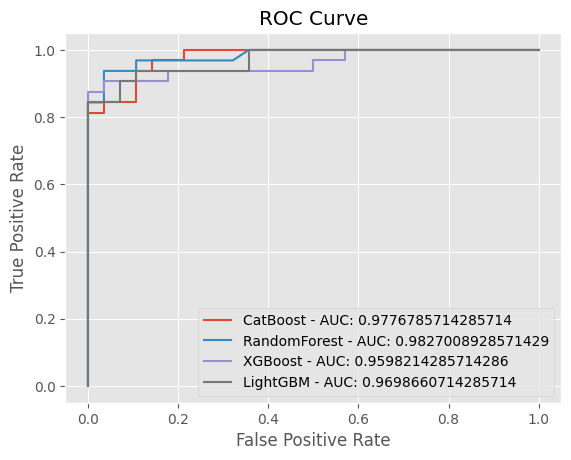

In [40]:
# Crear un diccionario con los modelos y sus respectivos parámetros para la búsqueda en cuadrícula
models = {
    'CatBoost': {
        'model': CatBoostClassifier(learning_rate=0.1, verbose=0),
        'param_grid': {
            'iterations': [100, 200, 300],
            'depth': [6, 8, 10],
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(learning_rate=0.1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(learning_rate=0.1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
        }
    }
}


# Diccionario para almacenar los mejores modelos de cada tipo
best_models_dict = {}

# Iterar sobre cada modelo
for model_name, model_info in models.items():
    print("\033[94m\033[1m" + "=="*10 + "\033[0m")
    print(f"\033[94m\033[1mTraining {model_name}...\033[0m")

    # training data: explanatory variables + response variables
    X, y = presencias_ausencia_encoded.iloc[:, [i for i in range(9, 0, -1)]].values, presencias_ausencia_encoded.iloc[:, 0].values

    # Realiza la estandarización de las características
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Divide los datos en conjuntos de entrenamiento y prueba después de la estandarización
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Definir los hiperparámetros que deseas ajustar en la búsqueda en cuadrícula
    param_grid = model_info['param_grid']

    # Realiza la búsqueda en cuadrícula con validación cruzada estratificada de 10 folds
    model = model_info['model']
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores parámetros encontrados
    best_params = grid_search.best_params_

    # Crea un modelo con los mejores parámetros
    best_model = model_info['model'].set_params(**best_params)

    best_models_dict[model_name] = best_model

    # Inicializa una lista para almacenar los informes de métricas
    metric_reports = []

    # Análisis de los resultados en cada fold
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

        best_model.fit(X_fold_train, y_fold_train)

        # Realiza predicciones en el conjunto de validación
        y_prob = best_model.predict_proba(X_fold_val)[:, 1]

        # Genera etiquetas binarias basadas en un umbral (ejemplo: 0.5)
        y_pred = (y_prob >= 0.5).astype(int)

        # Calcula las métricas para el fold actual
        roc_auc_score_val = roc_auc_score(y_fold_val, y_prob)


        metric_reports.append((fold, roc_auc_score_val))

        print(f'Fold {fold + 1} - AUC: {roc_auc_score_val}')
        print()

    # Entrena el modelo final con los mejores parámetros en el conjunto de entrenamiento
    best_model.fit(X_train, y_train)

    # Realiza predicciones en el conjunto de prueba
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Genera etiquetas binarias basadas en un umbral (ejemplo: 0.5)
    y_pred = (y_prob >= 0.5).astype(int)

    # Calcula la curva ROC
    fper, tper, thresholds = roc_curve(y_test, y_prob)

    # Grafica la curva ROC
    plt.plot(fper, tper, label=f'{model_name} - AUC: {auc(fper, tper)}')

# Muestra la leyenda y el gráfico de la curva ROC
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#DEB887; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #4682B4">4.2 Infenrence</p>

In [41]:
import folium
from folium.plugins import HeatMap
import webbrowser
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np

# Crea diccionario para almacenar las listas de coordenadas
coordenadas_dict = {"decimalLongitude": [], "decimalLatitude": []}

# Itera a través de las geometrías y extrae las coordenadas
for index, row in CNAT.iterrows():
    coordenadas = row['geometry'].exterior.coords[:]
    for punto in coordenadas:
        longitud, latitud = punto
        coordenadas_dict["decimalLongitude"].append(longitud)
        coordenadas_dict["decimalLatitude"].append(latitud)

# Crea un DataFrame a partir del diccionario
dfa = pd.DataFrame(coordenadas_dict)
dfa['geometry'] = [Point(lon, lat) for lon, lat in zip(dfa['decimalLongitude'], dfa['decimalLatitude'])]
gdf = gpd.GeoDataFrame(dfa, geometry='geometry')
gdf = gdf.set_crs(epsg=4326)  # Definir el CRS como WGS 84 (Latitud/Longitud)
ABSENT = create_absence_points(gdf, CNAT, 10, (dfa.shape[0]))
dfa = pd.concat([gdf, ABSENT], axis = 0).drop(["geometry", "Presencia"], axis = 1).reset_index()
prob_df = dfa.copy()

dfa["Fecha"] = pd.to_datetime("2023-11-30")
dfa["Año"] = dfa["Fecha"].dt.year
dfa["Mes"] = dfa["Fecha"].dt.month
coord_list = list(zip(dfa['decimalLongitude'], dfa['decimalLatitude']))
month = dfa.Fecha.dt.month.unique()[0]
for archivo in variable_dataset("/kaggle/input/bioclimworlddata"):
    archivos = variable_dataset(archivo)
    indice = [i for i, archivo in enumerate(archivos) if f'_0{month}.' in archivo or f'_{month}.' in archivo]
    src = rasterio.open(archivos[indice[0]])
    dfa[Path(archivos[indice[0]]).stem] = [x for x in src.sample(coord_list)]
    dfa[Path(archivos[indice[0]]).stem] = dfa[Path(archivos[indice[0]]).stem].astype('float64')
    # Nombres nuevos para las columnas
    
    
test = dfa[["Mes", "Año", "wc2.1_30s_tavg_11", "wc2.1_30s_prec_11", "wc2.1_30s_vapr_11", "wc2.1_30s_tmin_11", "wc2.1_30s_wind_11", "wc2.1_30s_srad_11", "wc2.1_30s_tmax_11"]].values
test = scaler.fit_transform(test)

probabilities_df = pd.DataFrame()

for model_name, best_model in best_models_dict.items():
    prob_predictions = best_model.predict_proba(test)[:, 1]
    probabilities_df[model_name] = prob_predictions

probabilities_df['Ensemble'] = probabilities_df.mean(axis=1)
prob_df['Ensemble_Target'] = probabilities_df['Ensemble']


prob_df['decimalLongitude'] = prob_df['decimalLongitude'].astype("float")
prob_df['decimalLatitude'] = prob_df['decimalLatitude'].astype("float")
prob_df['geometry'] = list(zip(prob_df['decimalLongitude'], prob_df['decimalLatitude']))
prob_df['geometry'] = prob_df['geometry'].apply(Point)
prob_df.reset_index(drop=True, inplace=True)

# Crear el GeoDataFrame
prob_df = gpd.GeoDataFrame(prob_df, crs='epsg:4326', geometry='geometry')
prob_df[list(dfa.columns[3:])] = dfa[dfa.columns[3:]]
prob_df.drop(["index", "decimalLongitude", "decimalLatitude", "Año", "Mes"], axis = 1).to_csv("ProbDist.csv", index = False)

In [43]:
from IPython.display import HTML

# Código de incrustación de Tableau con ajuste de tamaño para Kaggle
tableau_embed_code = """"
<div class='tableauPlaceholder' id='viz1699832683261' style='position: relative'><noscript><a href='#'><img alt='Regiones ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ce&#47;CerrejnBiodiversity-KaggleVersion&#47;Regiones&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CerrejnBiodiversity-KaggleVersion&#47;Regiones' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ce&#47;CerrejnBiodiversity-KaggleVersion&#47;Regiones&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='es-ES' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1699832683261');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='627px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='627px';} else { vizElement.style.width='100%';vizElement.style.height='1327px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>
"""

# Mostrar el código incrustado en el notebook
display(HTML(tableau_embed_code))